In [21]:
import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [28]:
DATASETPATH = '/Users/stack/Downloads/flowers.hdf5'
CHKPATH = '/Users/stack/Documents/warudo/t2i_checkpoints'
SAVEPATH = '/Users/stack/Documents/warudo/t2i_save'
BATCHSIZE = 64
LR = 0.0002
NUMWORKERS = 0
EPOCHS = 100
L1COEF = 50
L2COEF = 100
B1 = 0.5

In [39]:
class t2iDS(Dataset):
    def __init__(self, filename, split):
        self.filename = filename
        self.split = split
        self.dataset = h5py.File(self.filename, 'r')
        self.keys = [str(k) for k in self.dataset[self.split].keys()]
    
    def __len__(self):
        return len(self.dataset[self.split])
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        data = self.dataset[self.split][key]
        
        right_im = bytes(np.array(data['img']))
        right_embed = np.array(data['embeddings'], dtype=float)
        wrong_im = bytes(np.array(self.get_wrong_im(data['class'])))
        random_embed = np.array(self.get_random_embed())
        
        right_im = Image.open(io.BytesIO(right_im)).resize((64,64))
        right_im = self.validate_im(right_im)
        wrong_im = Image.open(io.BytesIO(wrong_im)).resize((64,64))
        wrong_im = self.validate_im(wrong_im)
        
        txt = np.array(data['txt']).astype(str)
        
        item = {
            'right_im': torch.FloatTensor(right_im).sub_(127.5).div_(127.5),
            'wrong_im': torch.FloatTensor(wrong_im).sub_(127.5).div_(127.5),
            'right_embed': torch.FloatTensor(right_embed),
            'random_embed': torch.FloatTensor(random_embed),
            'txt': str(txt)
        }
        
        return item
    
    def get_wrong_im(self, clas):
        idx = np.random.randint(len(self.keys))
        key = self.keys[idx]
        data = self.dataset[self.split][key]
        _clas = data['class']
        return data['img'] if (_clas != clas) else self.get_wrong_im(clas)
    
    def get_random_embed(self):
        idx = np.random.randint(len(self.keys))
        key = self.keys[idx]
        data = self.dataset[self.split][key]
        return data['embeddings']
    
    def validate_im(self, im):
        im = np.array(im, dtype=float)
        if len(im.shape) < 3:
            rgb = np.empty((64,64,3), dtype=np.float32)
            rgb[:,:,0] = im
            rgb[:,:,1] = im
            rgb[:,:,2] = im
            im = rgb
        return im.transpose(2,0,1)

In [52]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.imsize = 64
        self.channels = 3
        self.noise_dim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = 64
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        
        self.G = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.ngf, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, embed_vector, z):
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        latent_vector = torch.cat([projected_embed, z], 1)
        return self.G(latent_vector)
    
class concat_embed(nn.Module):
    def __init__(self, embed_dim, projected_embed_dim):
        super(concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
    
    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        return torch.cat([inp, replicated_embed], 1)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.imsize = 64
        self.channels = 3
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.ndf = 64
        
        self.D1 = nn.Sequential(
            nn.Conv2d(self.channels, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.projector = concat_embed(self.embed_dim, self.projected_embed_dim)
        
        self.D2 = nn.Sequential(
            nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, inp, embed):
        x_intermediate = self.D1(inp)
        x = self.projector(x_intermediate, embed)
        x = self.D2(x)
        return x.view(-1, 1).squeeze(1), x_intermediate

In [68]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def draw(im1, im2):
    clear_output(wait=True)
    plt.subplot(1,2,1)
    plt.imshow(im1.cpu()[0].permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(im2.detach().cpu()[0].permute(1,2,0))
    plt.show()

def save_chk(G, D, epoch):
    torch.save(G.state_dict(), os.path.join(CHKPATH, "gen" + str(epoch) + ".pth"))
    torch.save(D.state_dict(), os.path.join(CHKPATH, "disc" + str(epoch) + ".pth"))

class Trainer(object):
    def __init__(self, g_chk_file=None, d_chk_file=None, split='train'):
        self.G = torch.nn.DataParallel(Generator().cuda())
        self.D = torch.nn.DataParallel(Discriminator().cuda())
        
        if g_chk_file is not None:
            self.G.load_state_dict(torch.load(g_chk_file))
        else:
            self.G.apply(init_weights)
        
        if d_chk_file is not None:
            self.D.load_state_dict(torch.load(d_chk_file))
        else:
            self.D.apply(init_weights)
        
        self.dataset = t2iDS(DATASETPATH, split)
        self.dataloader = DataLoader(self.dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=NUMWORKERS)
        
        self.optimG = torch.optim.Adam(self.G.parameters(), lr=LR, betas=(B1, 0.999))
        self.optimD = torch.optim.Adam(self.D.parameters(), lr=LR, betas=(B1, 0.999))
    
    def train(self):
        criterion = nn.BCELoss()
        l2 = nn.MSELoss()
        l1 = nn.L1Loss()
        iteration = 0
        
        for epoch in range(EPOCHS):
            for sample in self.dataloader:
                iteration += 1
                right_im = sample['right_im']
                right_embed = sample['right_embed']
                wrong_im = sample['wrong_im']
                
                right_im = Variable(right_im.float()).cuda()
                right_embed = Variable(right_embed.float()).cuda()
                wrong_im = Variable(wrong_im.float()).cuda()
                
                real_labels = torch.ones(right_im.size(0))
                fake_labels = torch.zeros(right_im.size(0))
                smoothed_real_labels = torch.FloatTensor(real_labels.numpy() - 0.1)
                
                real_labels = Variable(real_labels).cuda()
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()
                
                self.D.zero_grad()
                outputs, _ = self.D(right_im, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs
                
                outputs, _ = self.D(wrong_im, right_embed)
                wrong_loss = criterion(outputs, fake_labels)
                wrong_score = outputs
                
                noise = Variable(torch.randn(right_im.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_im = self.G(right_embed, noise)
                outputs, _ = self.D(fake_im, right_embed)
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs
                
                d_loss = real_loss + wrong_loss + fake_loss
                d_loss.backward()
                self.optimD.step()
                
                self.G.zero_grad()
                noise = Variable(torch.randn(right_im.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_im = self.G(right_embed, noise)
                outputs, activation_fake = self.D(fake_im, right_embed)
                _, activation_real = self.D(right_im, right_embed)
                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)
                
                g_loss = criterion(outputs, real_labels) + L2COEF * l2(activation_fake, activation_real.detach()) + L1COEF * l1(fake_im, right_im)
                g_loss.backward()
                self.optimG.step()
                
                if iteration % 5 == 0:
                    draw(right_im, fake_im)
            
            if epoch % 10 == 0:
                save_chk(self.G, self.D, epoch)

In [69]:
t = Trainer()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


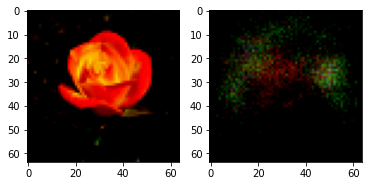

KeyboardInterrupt: 

In [70]:
t.train()